# 1D harmonic oscillator physics-informed neural network (PINN) using Equinox

This notebook contains an Equinox implementation of the PINN example presented in the blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using [Equinox](https://docs.kidger.site/equinox/) and [JAX](https://docs.jax.dev/en/latest/index.html), using the following environment set up:

> Recommended to use [uv](https://docs.astral.sh/uv/) for the environment management.



```bash
uv venv .venv
source .venv/bin/activate  # On Windows use `.venv\Scripts\activate`
uv pip install jupyter numpy matplotlib
uv pip install equinox optax loguru jax tqdm plotly
```



In [1]:
from PIL import Image

from tqdm.notebook import tqdm
from loguru import logger

import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [2]:
# Methods for plotting and saving GIFs


def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(
        fp=outfile,
        format="GIF",
        append_images=imgs[1:],
        save_all=True,
        duration=int(1000 / fps),
        loop=loop,
    )


def plot_result(x, y, x_data, y_data, yh, xp=None, step: int = 0):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(
        x,
        yh,
        color="tab:blue",
        linewidth=4,
        alpha=0.8,
        label="Neural network prediction",
    )
    plt.scatter(
        x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training data"
    )
    if xp is not None:
        plt.scatter(
            xp,
            jnp.zeros_like(xp),
            s=60,
            color="tab:green",
            alpha=0.4,
            label="Physics loss training locations",
        )
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, f"Training step: {step}", fontsize="xx-large", color="k")
    plt.axis("off")
    plt.tight_layout()


In [3]:
# Definition for the exact solution to the 1D underdamped harmonic oscillator problem

from dataclasses import dataclass
from typing import Optional


class HarmonicOscillator(object):
    """Class for the 1D underdamped harmonic oscillator problem."""

    def __init__(
        self,
        x: Optional[jnp.ndarray] = None,
        d: float = 2.0,
        w0: float = 20.0,
        initial_position: float = 1.0,
    ):
        """Initialize the class with parameters.

        Args:
            d: Damping coefficient
            w0: Natural frequency
            x: Time points
            initial_position: Initial position at t=0 (default=1.0)
        """
        self.x = x
        self.d = d
        self.w0 = w0
        self.initial_position = initial_position

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """Compute the exact solution."""
        self.x = x
        return self.exact(self.x, self.d, self.w0, self.initial_position)

    @staticmethod
    def exact(x: float, d: float, w0: float, initial_position) -> jnp.ndarray:
        """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
        Equations taken from: https://beltoforion.de/en/harmonic_oscillator/

        Args:
            d: Damping coefficient
            w0: Natural frequency
            x: Time points
            initial_position: Initial position at t=0 (default=1.0)

        Returns:
            y: Position values at the time points
        """

        if not d < w0:
            raise ValueError(
                "Damping coefficient (d) must be less than natural frequency (w0) for underdamped oscillation."
            )

        w = jnp.sqrt(w0**2 - d**2)

        phi = jnp.arctan(-d / w)

        A = initial_position / (2 * jnp.cos(phi))
        cos = jnp.cos(phi + w * x)
        sin = jnp.sin(phi + w * x)
        exp = jnp.exp(-d * x)
        y = exp * 2 * A * cos
        return y


@dataclass
class Data:
    """dataclass for storing data."""

    x: jnp.ndarray
    y: jnp.ndarray


## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

In [4]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = jnp.linspace(0, 1, 500)
oscillator = HarmonicOscillator(d=d, w0=w0)
# get the analytical solution over the full domain
y = oscillator(x)

exact = Data(x, y)

y2 = oscillator.exact(x, d=d, w0=w0, initial_position=2.0)  # different initial position
print(x.shape, y.shape)

# slice out a small number of points from the start
train = Data(x=x[0:200:20], y=y[0:200:20])  # 10 points from the first 200 points
print(train.x.shape, train.y.shape)


@dataclass
class PlotData:
    data: Data
    plot_type: str = "scatter"  # "scatter" or "line"
    line_style: tuple[str, str] = ("-", "solid")  # line style and dash style
    color: Optional[str] = None
    label: Optional[str] = None
    alpha: float = 0.5
    marker: Optional[str] = None


def plot_basic(data: list[PlotData]):
    import matplotlib.pyplot as plt

    plt.figure()

    for d in data:
        if d.plot_type == "scatter":
            plt.scatter(d.data.x, d.data.y, c=d.color, label=d.label, alpha=d.alpha)
        elif d.plot_type == "line":
            plt.plot(
                d.data.x,
                d.data.y,
                d.line_style[0],
                c=d.color,
                label=d.label,
                alpha=d.alpha,
            )
        else:
            raise ValueError("plot_type must be 'scatter' or 'line'")
    plt.legend()
    plt.show()


def plot_interactive(data: list[PlotData]):
    import plotly.graph_objects as go

    fig = go.Figure()

    for d in data:
        if d.plot_type == "scatter":
            fig.add_trace(
                go.Scatter(
                    x=d.data.x,
                    y=d.data.y,
                    mode="markers",
                    name=d.label,
                    marker=dict(color=d.color),
                )
            )
        elif d.plot_type == "line":
            fig.add_trace(
                go.Scatter(
                    x=d.data.x,
                    y=d.data.y,
                    mode="lines",
                    name=d.label,
                    line=dict(color=d.color, dash=d.line_style[1]),
                )
            )
        else:
            raise ValueError("plot_type must be 'scatter' or 'line'")
    fig.update_layout(width=800)
    fig.show()


exact_plot = PlotData(data=exact, plot_type="line", label="Exact solution")
train_plot = PlotData(
    data=train, plot_type="scatter", color="orange", label="Training data"
)
different_plot = PlotData(
    data=Data(x=x, y=y2),
    plot_type="line",
    line_style=("--", "dash"),
    label="Exact solution with different initial position",
    color="green",
)

# plot_basic([exact_plot, train_plot, different_plot])
plot_interactive([exact_plot, train_plot, different_plot])


(500,) (500,)
(10,) (10,)


## Equinox Neural Network

Next, we define and train a standard neural network using Equinox to fit these training points.

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [5]:
class Network(eqx.Module):
    """Simple feedforward neural network."""

    layers: list[eqx.nn.Linear]

    def __init__(self, layer_sizes: list[int], key: jax.random.PRNGKey):
        """Initialize the neural network.

        Args:
            n_hidden: Number of hidden units
            n_layers: Number of layers
        """

        def single_to_scalar(x):
            """Convert a single value to a scalar."""
            return "scalar" if x == 1 else x

        layer_sizes = [single_to_scalar(x) for x in layer_sizes]

        self.layers = []
        for fan_in, fan_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)

            # Create a linear layer with the given input and output dimensions
            # and a random key for initialization
            # Note: The key is split for each layer to ensure different initializations
            # for each layer
            layer = eqx.nn.Linear(fan_in, fan_out, key=subkey)
            self.layers.append(layer)

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """Forward pass through the network."""

        a = x
        for layer in self.layers[:-1]:
            a = jax.nn.tanh(layer(a))
        a = self.layers[-1](a)
        return a

In [6]:
key = jax.random.PRNGKey(0)

model = Network(
    layer_sizes=[1, 16, 16, 16, 16, 1], key=key
)  # 1 input, 4 hidden layers with 16 units, 1 output

In [7]:
# Initial state of the model

model_y0 = jax.vmap(model)(exact.x)

initial_model = Data(exact.x, model_y0)

plot_interactive(
    [
        exact_plot,
        train_plot,
        PlotData(
            data=initial_model,
            plot_type="line",
            line_style=("--", "dash"),
            label="Initial model prediction",
            color="red",
        ),
    ]
)

In [8]:
def loss_fn(model, x, y_true):
    y_pred = jax.vmap(model)(x)
    return jnp.mean((y_pred - y_true) ** 2)


def loss_fn_with_grad(model):
    """Compute the loss and its gradient."""
    return eqx.filter_value_and_grad(model)

In [9]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [10]:
@eqx.filter_jit
def update_step(model, optimizer_state, x, y):
    loss_value, grads = loss_fn_with_grad(loss_fn)(model, x, y)

    updates, optimizer_state = optimizer.update(grads, optimizer_state)

    model = eqx.apply_updates(model, updates)

    return model, optimizer_state, loss_value

  0%|          | 0/5001 [00:00<?, ?it/s]

2025-11-20 10:37:41.205 | INFO     | __main__:<module>:13 - Epoch 0: loss = 0.2954


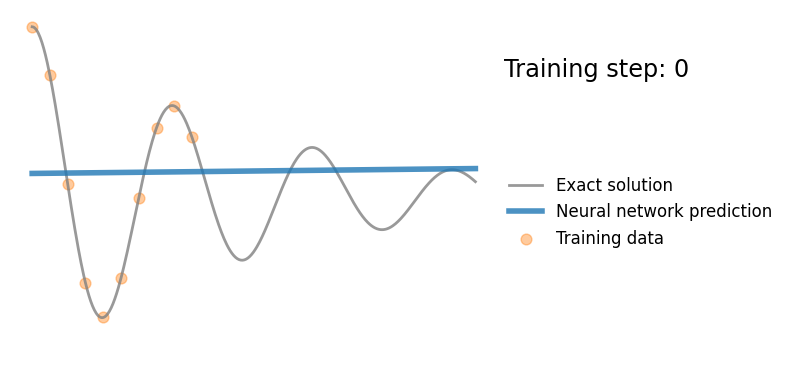

2025-11-20 10:37:41.477 | INFO     | __main__:<module>:13 - Epoch 1000: loss = 0.0000


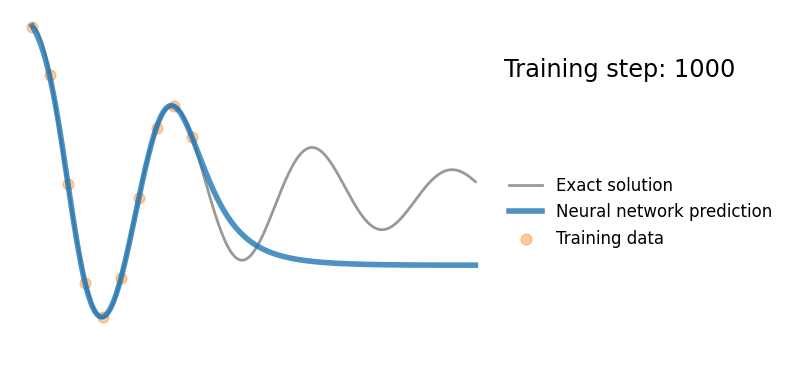

2025-11-20 10:37:41.670 | INFO     | __main__:<module>:13 - Epoch 2000: loss = 0.0000


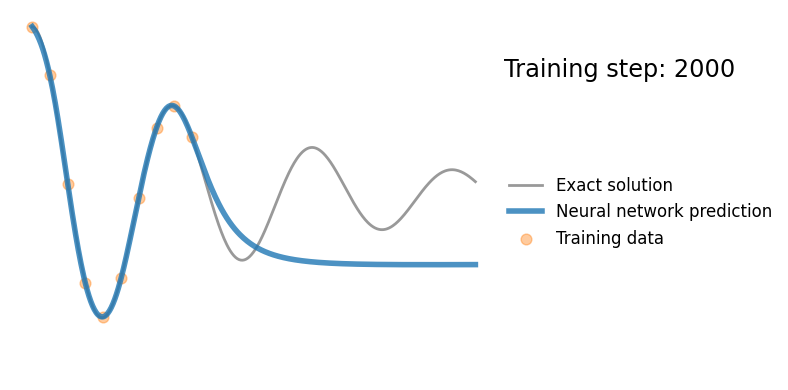

2025-11-20 10:37:41.855 | INFO     | __main__:<module>:13 - Epoch 3000: loss = 0.0000


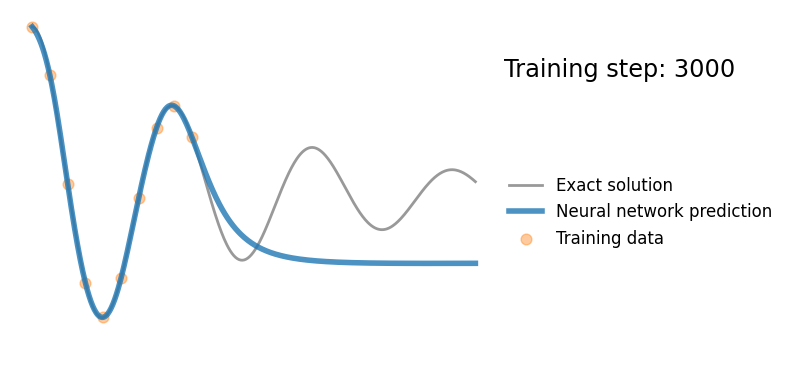

2025-11-20 10:37:42.041 | INFO     | __main__:<module>:13 - Epoch 4000: loss = 0.0000


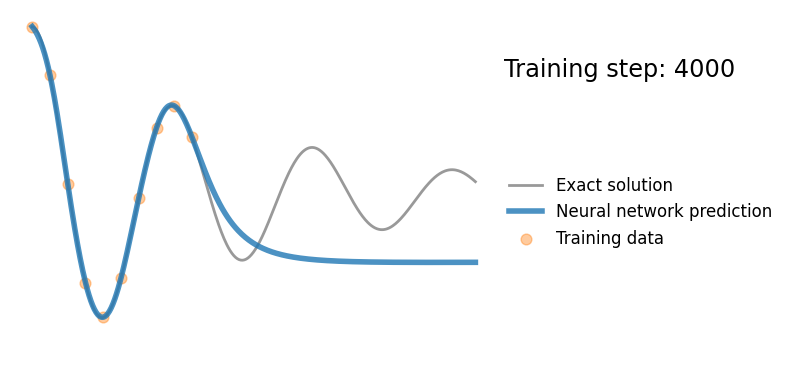

2025-11-20 10:37:42.235 | INFO     | __main__:<module>:13 - Epoch 5000: loss = 0.0000


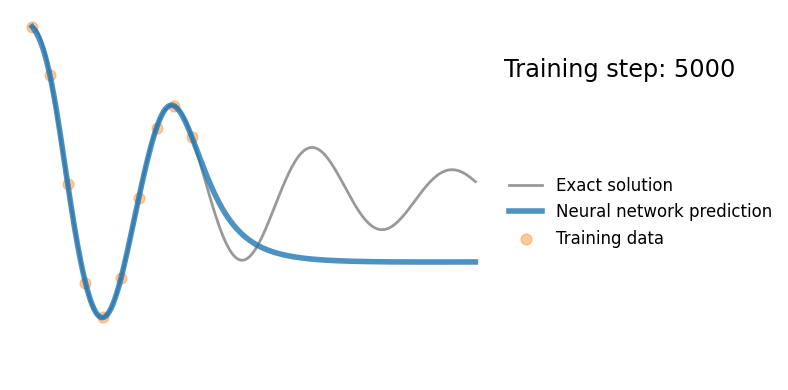

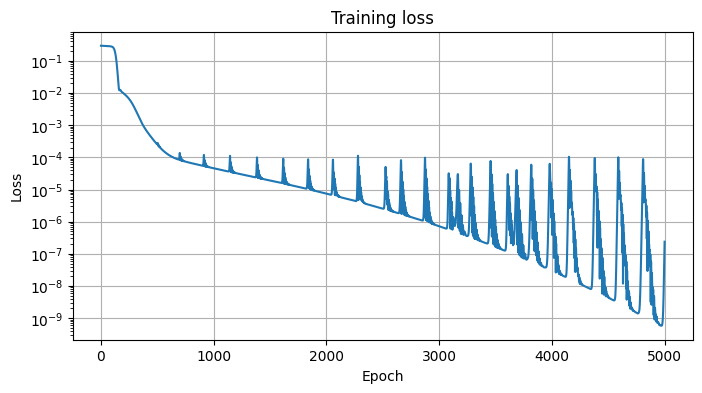

In [11]:
loss_record = []

N_EPOCHS = 5000
N_FIGS_SHOWN = 5
SHOW_INTERVAL = N_EPOCHS // N_FIGS_SHOWN
for epoch in tqdm(range(N_EPOCHS + 1)):
    model, opt_state, loss = update_step(
        model, opt_state, train.x, train.y
    )  # update the model
    loss_record.append(loss)

    if epoch % SHOW_INTERVAL == 0:
        logger.info(f"Epoch {epoch}: loss = {loss:.4f}")
        model_y = jax.vmap(model)(exact.x)
        plot_result(
            exact.x,
            exact.y,
            train.x,
            train.y,
            model_y,
            step=epoch,
        )
        plt.show()

plt.figure(figsize=(8, 4))
plt.plot(loss_record)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.yscale("log")
plt.grid()
plt.show()

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using JAX's automatic differentiation, and can then easily compute the residual of the differential equation using these quantities.

In [12]:
from pathlib import Path


class NetworkWithPhysics(eqx.Module):
    """Feedforward neural network with trainable physics parameters."""

    layers: list[eqx.nn.Linear]
    d: jnp.ndarray  # Trainable damping coefficient
    w0: jnp.ndarray  # Trainable natural frequency

    def __init__(
        self,
        layer_sizes: list[int],
        d: jnp.ndarray,
        w0: jnp.ndarray,
        key: jax.random.PRNGKey,
    ):
        """Initialize the neural network with trainable physics parameters.

        Args:
            layer_sizes: List of layer sizes for the network.
            d: Initial value for damping coefficient.
            w0: Initial value for natural frequency.
            key: PRNG key for initializing weights.
        """
        self.layers = []

        def single_to_scalar(x):
            """Convert a single value to a scalar."""
            return "scalar" if x == 1 else x

        layer_sizes = [single_to_scalar(x) for x in layer_sizes]

        key, subkey = jax.random.split(key)
        for fan_in, fan_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer = eqx.nn.Linear(fan_in, fan_out, key=subkey)
            self.layers.append(layer)

        # Initialize trainable parameters as jnp arrays
        self.d = d
        self.w0 = w0

    def __call__(self, x: float) -> float:
        """Forward pass through the network."""

        a = x
        for layer in self.layers[:-1]:
            a = jax.nn.tanh(layer(a))
        a = self.layers[-1](a)

        return a

    def from_binary(self, file: str | Path) -> "NetworkWithPhysics":
        """Load the model paramaters from a binary file."""

        return eqx.tree_deserialise_leaves(file, self)

    def to_binary(self, file: str | Path) -> None:
        """Save the model parameters to a binary file."""
        eqx.tree_serialise_leaves(file, self)

In [13]:
def init_pinn(key):
    key, subkey = jax.random.split(key)

    pinn = NetworkWithPhysics(
        layer_sizes=[1, 16, 16, 16, 1],  # Define the network architecture
        d=jnp.array(1.0),  # Initial value for damping coefficient
        w0=jnp.array(10.0),  # Initial value for natural frequency
        key=subkey,
    )
    return pinn


key = jax.random.PRNGKey(0)

pinn = init_pinn(key)

In [14]:
pinn(0.2)

Array(0.34181064, dtype=float32)

In [15]:
jax.vmap(pinn)(jnp.array([0.2, 0.4, 0.6, 0.8]))  # Test the model with some inputs


Array([0.3418106 , 0.35463205, 0.36635002, 0.3761417 ], dtype=float32)

In [16]:
plot_interactive(
    [
        exact_plot,
        train_plot,
        PlotData(
            data=Data(x=x, y=jax.vmap(pinn)(x)),
            plot_type="line",
            line_style=("--", "dash"),
            label="Initial model prediction",
            color="red",
        ),
    ]
)


In [17]:
print("first derivative", jax.grad(pinn)(0.2))
print("second derivative", jax.grad(jax.grad(pinn))(0.2))

first derivative 0.0651356
second derivative -0.0010621273


In [18]:
jax.vmap(jax.grad(pinn))(
    jnp.array([0.2, 0.4, 0.6, 0.8])
)  # Test the model with some inputs

Array([0.06513558, 0.06217312, 0.05430471, 0.04327197], dtype=float32)

In [19]:
def pde_loss(model: NetworkWithPhysics, x):
    """Compute the PDE loss using known."""

    y = jax.vmap(model)(x)
    y_dot = jax.vmap(jax.grad(model))(x)
    y_ddot = jax.vmap(jax.grad(jax.grad(model)))(x)  # Compute the second derivative

    # Use known parameters for the model
    d = model.d
    w0 = model.w0

    residual = y_ddot + 2 * d * y_dot + w0**2 * y
    return jnp.mean(residual**2)

In [20]:
pde_loss(pinn, exact.x)


Array(1297.9453, dtype=float32)

In [21]:
def nn_loss(model, x_train, y_train):
    """Compute the initial condition loss."""
    y_pred = jax.vmap(model)(x_train)
    return jnp.mean((y_pred - y_train) ** 2)


In [22]:
nn_loss(pinn, train.x, train.y)

Array(0.34087917, dtype=float32)

In [23]:
def ic_loss(model, x0=0.0, y0=1.0, v0=0.0):
    """Compute the initial condition loss."""
    y_pred = model(x0)
    v_pred = jax.grad(model)(x0)
    return jnp.mean((v_pred - v0) ** 2) + jnp.mean((y_pred - y0) ** 2)

In [24]:
ic_loss(pinn, 0.0, 1.0, 0.0)


Array(0.45424283, dtype=float32)

In [25]:
def total_loss(model, x_train, y_train, x_physics):
    """Compute the total loss."""
    return (
        nn_loss(model, x_train, y_train)
        + 1e-2 * pde_loss(model, x_physics)
        + 10.0 * ic_loss(model)
    )

In [26]:
@eqx.filter_jit
def update_step_pinn(model, optimizer_state, x_train, y_train, x_physics):
    """Update step for the PINN model."""
    loss_value, grads = eqx.filter_value_and_grad(total_loss)(
        model, x_train, y_train, x_physics
    )

    updates, optimizer_state = optimizer.update(grads, optimizer_state)

    model = eqx.apply_updates(model, updates)

    return model, optimizer_state, loss_value

In [27]:
def init_trainer():
    """Initialize the optimizer."""
    key = jax.random.PRNGKey(0)
    key, subkey = jax.random.split(key)

    pinn = init_pinn(subkey)
    # Initialize the optimizer
    optimizer = optax.adam(1e-3)
    opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

    return pinn, optimizer, opt_state


  0%|          | 0/500001 [00:00<?, ?it/s]

2025-11-20 10:37:44.617 | INFO     | __main__:<module>:37 - Epoch 0: loss = 29.0792 w0 = 9.9990 d = 1.0010


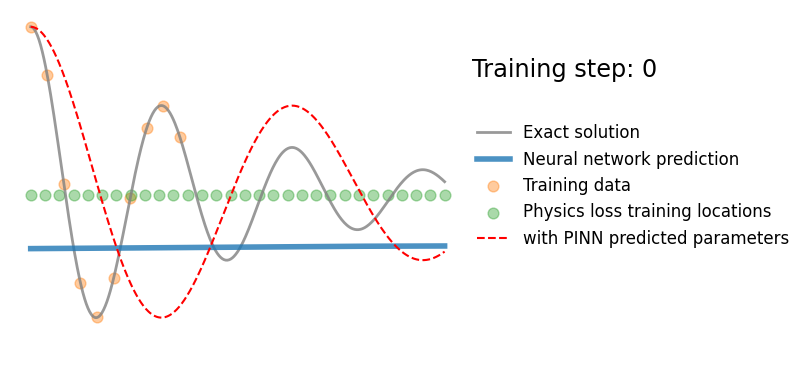

2025-11-20 10:38:07.990 | INFO     | __main__:<module>:37 - Epoch 100000: loss = 0.0162 w0 = 20.0416 d = 3.4144


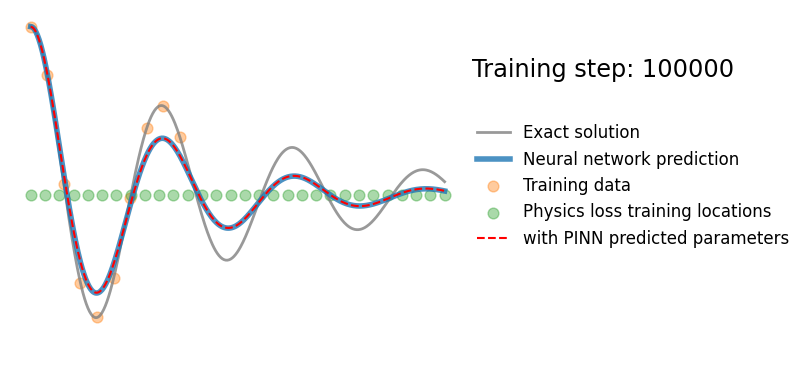

2025-11-20 10:38:30.932 | INFO     | __main__:<module>:37 - Epoch 200000: loss = 0.0003 w0 = 19.9397 d = 2.1055


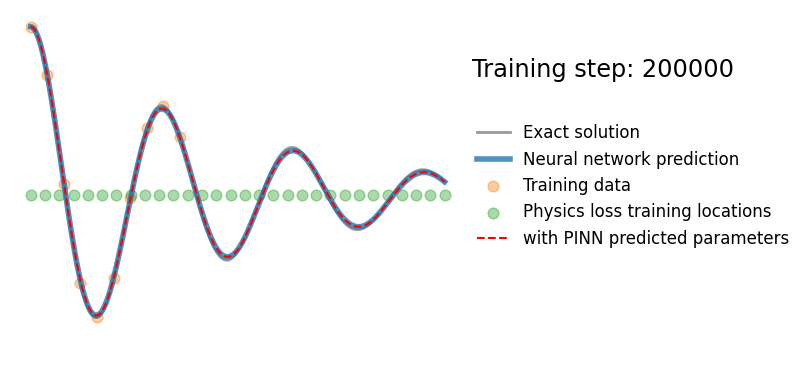

2025-11-20 10:38:54.666 | INFO     | __main__:<module>:37 - Epoch 300000: loss = 0.0034 w0 = 19.9647 d = 2.0526


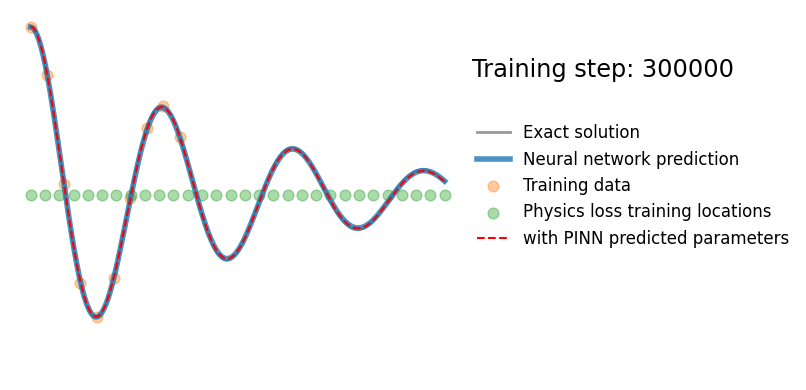

2025-11-20 10:39:18.222 | INFO     | __main__:<module>:37 - Epoch 400000: loss = 0.0001 w0 = 19.9878 d = 2.0320


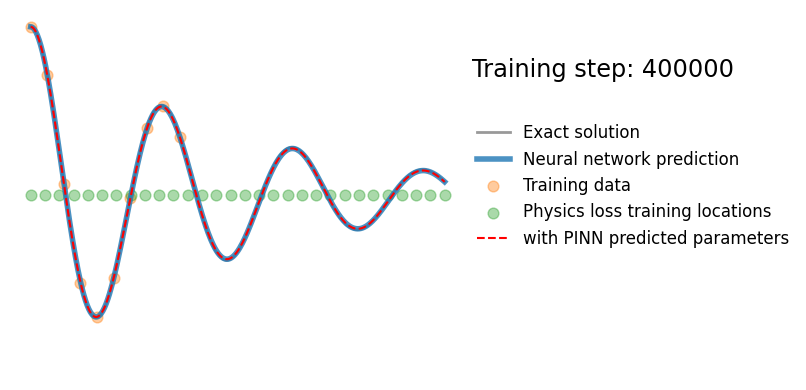

2025-11-20 10:39:40.678 | INFO     | __main__:<module>:37 - Epoch 500000: loss = 0.0014 w0 = 20.0194 d = 2.0226


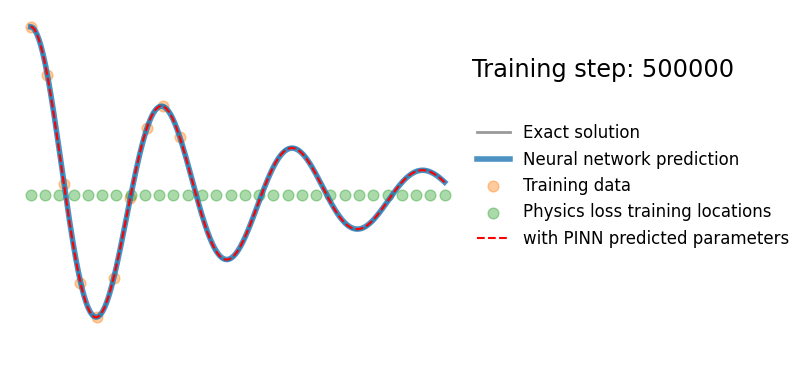

In [28]:
# Train the PINN model
# Define the physics loss locations
x_physics = jnp.linspace(0, 1, 30)

pinn, optimizer, opt_state = init_trainer()


class Metrics(object):
    def __init__(self):
        self.loss = []
        self.w0 = []
        self.d = []

    def add(self, loss, w0, d):
        self.loss.append(loss)
        self.w0.append(w0)
        self.d.append(d)


N_EPOCHS = int(5e5)
N_FIG_SHOW = 5
N_INTERVAL = N_EPOCHS // N_FIG_SHOW

metrics = Metrics()

for epoch in tqdm(range(N_EPOCHS + 1)):
    pinn, opt_state, loss = update_step_pinn(
        pinn, opt_state, train.x, train.y, x_physics
    )  # update the model

    metrics.add(loss, pinn.w0, pinn.d)
    # logger.info(
    #     f"Epoch {epoch}: loss = {loss:.4f}, w0 = {pinn.w0:.4f}, d = {pinn.d:.4f}"
    # )

    if epoch % N_INTERVAL == 0:
        logger.info(
            f"Epoch {epoch}: loss = {loss:.4f} w0 = {pinn.w0:.4f} d = {pinn.d:.4f}"
        )
        model_y = jax.vmap(pinn)(exact.x)

        plot_result(
            exact.x,
            exact.y,
            train.x,
            train.y,
            model_y,
            xp=x_physics,
            step=epoch,
        )
        plt.plot(
            exact.x,
            HarmonicOscillator.exact(
                exact.x, d=pinn.d, w0=pinn.w0, initial_position=1.0
            ),
            label="with PINN predicted parameters",
            linestyle="--",
            c="red",
        )
        plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")

        plt.show()


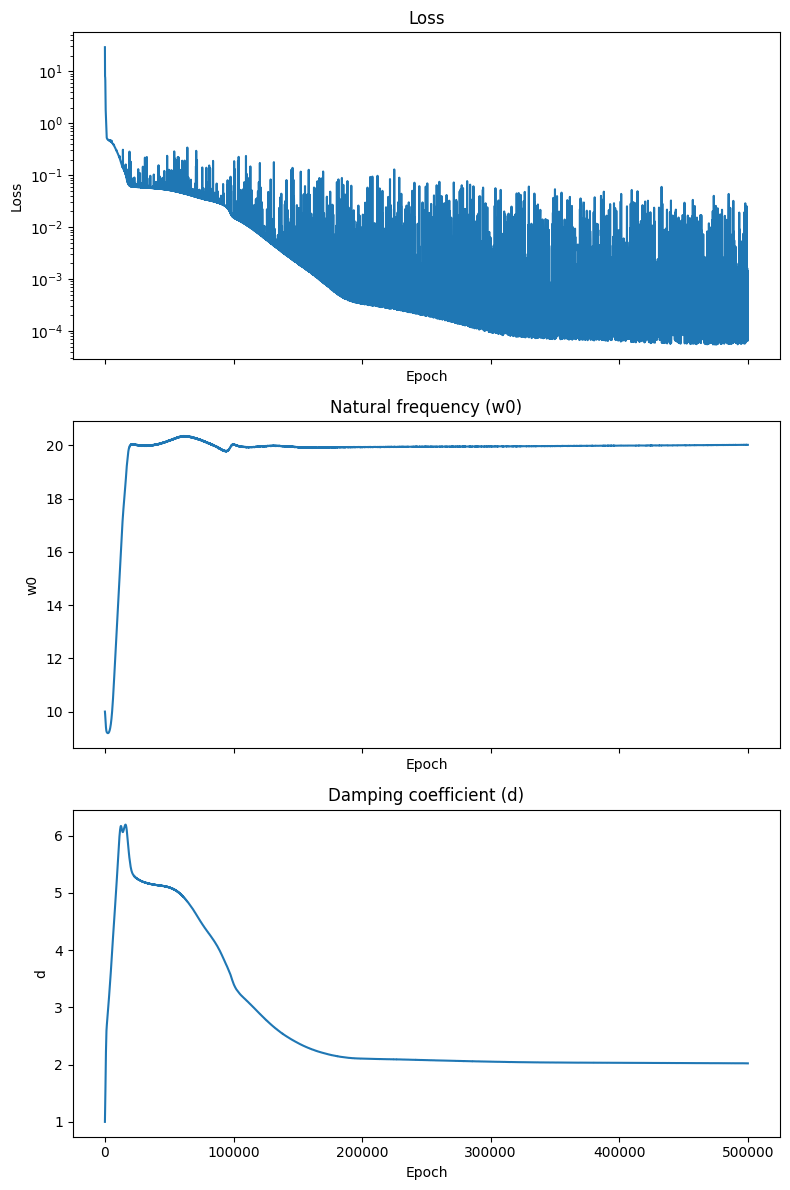

In [29]:
# plot the metrics in subplots
markevery = 100
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
epochs_x = jnp.arange(len(metrics.loss))
axs[0].plot(epochs_x[::markevery], metrics.loss[::markevery])
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_yscale("log")

axs[1].plot(epochs_x[::markevery], metrics.w0[::markevery])
axs[1].set_title("Natural frequency (w0)")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("w0")

axs[2].plot(epochs_x[::markevery], metrics.d[::markevery])
axs[2].set_title("Damping coefficient (d)")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("d")

plt.tight_layout()
plt.show()

# How to save the trained model and reload it later

In [30]:
# save the model parameters to a binary file
pinn.to_binary("pinn_model.bin")

# initialize a new pinn model
pinn_new, optimizer, opt_state = init_trainer()

# load the model parameters from the binary file
pinn_new = pinn_new.from_binary("pinn_model.bin")

In [31]:
pinn_data = Data(
    x=exact.x,
    y=jax.vmap(pinn)(exact.x),
)

loaded_model = Data(
    x=exact.x,
    y=jax.vmap(pinn_new)(exact.x),
)

plot_interactive(
    [
        exact_plot,
        train_plot,
        PlotData(data=pinn_data, plot_type="line", label="PINN model prediction"),
        PlotData(
            data=loaded_model,
            plot_type="line",
            line_style=("--", "dash"),
            label="Loaded model prediction",
            color="red",
        ),
    ]
)